# Tutorial for using structure factor data as the structure factor used in the structural-color package
This tutorial describes how to add your own structor factor data to Monte Carlo calculations

Copyright 2016, Vinothan N. Manoharan, Victoria Hwang, Annie Stephenson

This file is part of the structural-color python package.

This package is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.

This package is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with this package. If not, see http://www.gnu.org/licenses/.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import structcol as sc
import structcol.refractive_index as ri
from structcol import montecarlo as mc
from structcol import detector as det
from structcol import structure

In [3]:
# The following will cause specific warnings to be ignored
import warnings
warnings.filterwarnings('ignore',
                        category=UserWarning,
                        message='.*n_particle and n_matrix not specified')

So that you can reproduce the results in this notebook, we use a seeded random number generator. The code will then produce the same trajectories each time. For your own code, you should change the cell below to read `rng=None`, or set up your own random number generator.

In [4]:
seed = 1
rng = np.random.RandomState([seed])
# Uncomment the following for your own code
#rng = None

### For the single scattering model

set parameters

In [5]:
wavelengths = sc.Quantity(np.arange(400, 800, 20), 'nm') # wavelengths
radius = sc.Quantity('0.5 um')                    # particle radius
volume_fraction = sc.Quantity(0.5, '')            # volume fraction of particles
n_particle = ri.n('fused silica', wavelengths)
n_matrix = ri.n('vacuum', wavelengths)            # called from the refractive_index module. n_matrix is the
n_medium = ri.n('vacuum', wavelengths)            # space within sample. n_medium is outside the sample.
                                                  # n_particle and n_matrix can have complex indices if absorption is desired
thickness = sc.Quantity('50 um')        # thickness of the sample film

Construct the structure factor data

Here, we use discrete points from the Percus-Yevick approximation for the structure factor, as an example. In practice, you will most likely use actual structure factor data imported from your own file.

In [6]:
qd_data = np.arange(0.001,75, 0.1)
s_data = structure.factor_py(qd_data, volume_fraction.magnitude)

plot the structure factor data and interpolated function

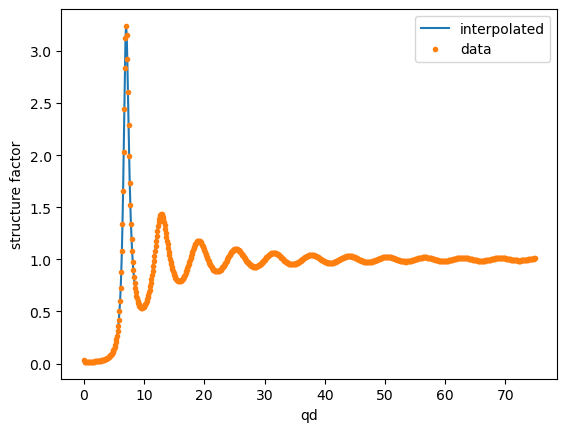

In [7]:
qd = np.arange(0, 70, 0.1) # works up to qd = 72
s = structure.factor_data(qd, s_data, qd_data)

plt.figure()
plt.plot(qd, s, label = 'interpolated')
plt.plot(qd_data, s_data,'.', label = 'data')
plt.legend()
plt.xlabel('qd')
plt.ylabel('structure factor');

Calculate reflectance

In [8]:
reflectance=np.zeros(len(wavelengths))
for i in range(len(wavelengths)):
    reflectance[i],_,_,_,_ = sc.model.reflection(n_particle[i], n_matrix[i], n_medium[i], wavelengths[i],
                                         radius, volume_fraction,
                                         thickness=thickness,
                                         structure_type='data',
                                         structure_s_data=s_data,
                                         structure_qd_data=qd_data)

plot

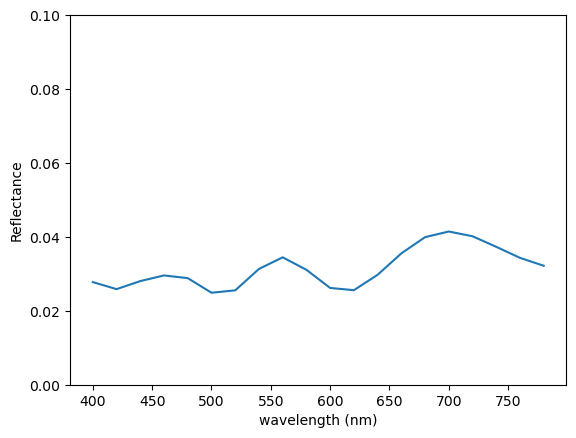

In [9]:
plt.figure()
plt.plot(wavelengths.magnitude, reflectance)
plt.ylim([0,0.1])
plt.ylabel('Reflectance')
plt.xlabel('wavelength (nm)');

### For the Monte Carlo model

set parameters

In [10]:
ntrajectories = 500                               # number of trajectories
nevents = 500                                     # number of scattering events in each trajectory
wavelengths = sc.Quantity(np.arange(400, 800, 20), 'nm') # wavelengths
radius = sc.Quantity('0.5 um')                    # particle radius
volume_fraction = sc.Quantity(0.5, '')            # volume fraction of particles
n_particle = ri.n('fused silica', wavelengths)
n_matrix = ri.n('vacuum', wavelengths)            # called from the refractive_index module. n_matrix is the
n_medium = ri.n('vacuum', wavelengths)            # space within sample. n_medium is outside the sample.
                                                  # n_particle and n_matrix can have complex indices if absorption is desired
boundary = 'film'                       # geometry of sample, can be 'film' or 'sphere', see below for tutorial
                                        # on sphere case
thickness = sc.Quantity('50 um')        # thickness of the sample film

Construct the structure factor data

Again, we use discrete points from the Percus-Yevick approximation. In practice, you will most likely use actual structure factor data imported from your own file

In [11]:
qd_data = np.arange(0.001,75, 0.1)
s_data = structure.factor_py(qd_data, volume_fraction.magnitude)

plot the structure factor data and interpolated function

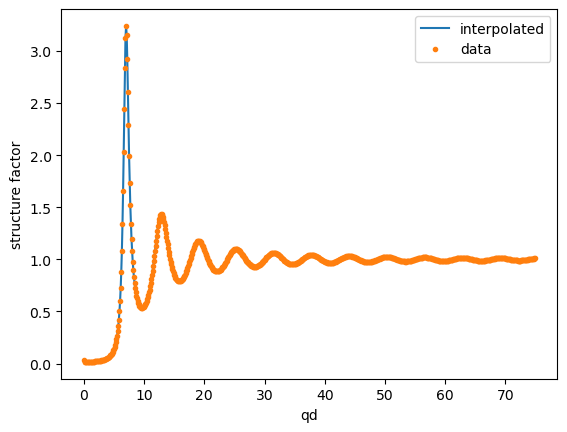

In [12]:
qd = np.arange(0.001,70, 0.1)# works up to qd = 72
s = structure.factor_data(qd, s_data, qd_data)

plt.figure()
plt.plot(qd, s, label = 'interpolated')
plt.plot(qd_data, s_data,'.', label = 'data')
plt.legend()
plt.xlabel('qd')
plt.ylabel('structure factor');

Calculate reflectance

In [13]:
reflectance = np.zeros(wavelengths.size)
for i in range(wavelengths.size):

    # calculate n_sample
    n_sample = ri.n_eff(n_particle[i], n_matrix[i], volume_fraction)

    # Calculate the phase function and scattering and absorption coefficients from the single scattering model
    p, mu_scat, mu_abs = mc.calc_scat(radius, n_particle[i], n_sample, volume_fraction, wavelengths[i],
                                      structure_type = 'data',
                                      structure_s_data = s_data,
                                      structure_qd_data = qd_data)

    # Initialize the trajectories
    r0, k0, W0 = mc.initialize(nevents, ntrajectories, n_medium[i],
                               n_sample, boundary, rng=rng)
    r0 = sc.Quantity(r0, 'um')
    k0 = sc.Quantity(k0, '')
    W0 = sc.Quantity(W0, '')

    # Generate a matrix of all the randomly sampled angles first
    sintheta, costheta, sinphi, cosphi, _, _ = mc.sample_angles(nevents, ntrajectories,
                                                                p, rng=rng)

    # Create step size distribution
    step = mc.sample_step(nevents, ntrajectories, mu_scat, rng=rng)

    # Create trajectories object
    trajectories = mc.Trajectory(r0, k0, W0)

    # Run photons
    trajectories.absorb(mu_abs, step)
    trajectories.scatter(sintheta, costheta, sinphi, cosphi)
    trajectories.move(step)

    reflectance[i], transmittance = det.calc_refl_trans(trajectories, thickness, n_medium[i],
                                                        n_sample, boundary)

plot

Text(0.5, 0, 'wavelength (nm)')

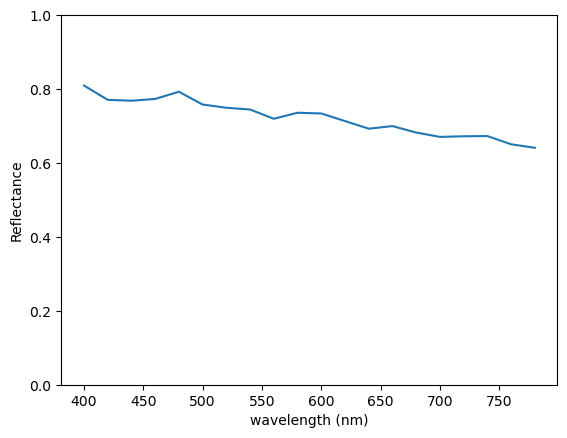

In [14]:
plt.figure()
plt.plot(wavelengths.magnitude, reflectance)
plt.ylim([0,1])
plt.ylabel('Reflectance')
plt.xlabel('wavelength (nm)')